In [25]:
!pip -q install torcheval

In [39]:
import warnings
warnings.filterwarnings("ignore")

In [27]:
!rm ./models/*.pkl

In [28]:
%%capture
# %%bash
!wget https://staffnet.kingston.ac.uk/~ku15565/CHASE_DB1/assets/CHASEDB1.zip
!unzip -d ./CHASEDB1 ./CHASEDB1.zip
# rm -r CHASEDB1
# rm -r CHASEDB1_GT
# rm -r dataset
# unzip -d CHASEDB1 CHASEDB1.zip

In [29]:
!kaggle datasets download -d andrewmvd/drive-digital-retinal-images-for-vessel-extraction
!unzip -qq ./drive-digital-retinal-images-for-vessel-extraction.zip

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/drive-digital-retinal-images-for-vessel-extraction
License(s): other
drive-digital-retinal-images-for-vessel-extraction.zip: Skipping, found more recently modified local copy (use --force to force download)
replace DRIVE/test/images/01_test.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Imports

In [30]:
import os
import re
import csv
import time
import torch
import random
import shutil
import datetime
import argparse
import numpy as np
import torchvision
import pandas as pd
import torch.nn as nn
from PIL import Image
from torch import optim
from torch.nn import init
from random import shuffle
from shutil import copyfile
from torch.utils import data
import matplotlib.pyplot as plt
from torch.backends import cudnn
import torch.nn.functional as nnF
from torch.autograd import Variable
from torchvision import transforms as T
from sklearn.model_selection import KFold
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, random_split
from torcheval.metrics import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score

# Misc

In [31]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
    # Print New Line on Complete
    if iteration == total:
        print()

# Dataloader

In [32]:
class CHASEDB1Dataset(data.Dataset):
	def __init__(self, root,image_size=224,mode='train',augmentation_prob=0.4):
		"""Initializes image paths and preprocessing module."""
		self.root = root
		self.GT_paths = root[:-1]+'_GT/'
		self.image_paths = list(map(lambda x: os.path.join(root, x), os.listdir(root)))
		self.image_size = image_size
		self.mode = mode
		self.RotationDegree = [0,90,180,270]
		self.augmentation_prob = augmentation_prob
		print("image count in {} path :{}".format(self.mode,len(self.image_paths)))

	def __getitem__(self, index):
		"""Reads an image from a file and preprocesses it and returns."""
		image_path = self.image_paths[index]
		filename = image_path.split('_')[-1][:-len(".jpg")]
		GT_path = self.GT_paths + 'Image_' + filename + '_1stHO.png'


		image = Image.open(image_path)
		GT = Image.open(GT_path)

		aspect_ratio = image.size[1]/image.size[0]

		Transform = []

		ResizeRange = random.randint(300,320)
		Transform.append(T.Resize((int(ResizeRange*aspect_ratio),ResizeRange)))
		p_transform = random.random()

		if (self.mode == 'train') and p_transform <= self.augmentation_prob:
			RotationDegree = random.randint(0,3)
			RotationDegree = self.RotationDegree[RotationDegree]
			if (RotationDegree == 90) or (RotationDegree == 270):
				aspect_ratio = 1/aspect_ratio

			Transform.append(T.RandomRotation((RotationDegree,RotationDegree)))

			RotationRange = random.randint(-10,10)
			Transform.append(T.RandomRotation((RotationRange,RotationRange)))
			CropRange = random.randint(250,270)
			Transform.append(T.CenterCrop((int(CropRange*aspect_ratio),CropRange)))
			Transform = T.Compose(Transform)

			image = Transform(image)
			GT = Transform(GT)

			ShiftRange_left = random.randint(0,20)
			ShiftRange_upper = random.randint(0,20)
			ShiftRange_right = image.size[0] - random.randint(0,20)
			ShiftRange_lower = image.size[1] - random.randint(0,20)
			image = image.crop(box=(ShiftRange_left,ShiftRange_upper,ShiftRange_right,ShiftRange_lower))
			GT = GT.crop(box=(ShiftRange_left,ShiftRange_upper,ShiftRange_right,ShiftRange_lower))

			if random.random() < 0.5:
				image = F.hflip(image)
				GT = F.hflip(GT)

			if random.random() < 0.5:
				image = F.vflip(image)
				GT = F.vflip(GT)

			Transform = T.ColorJitter(brightness=0.2,contrast=0.2,hue=0.02)

			image = Transform(image)

			Transform =[]


		Transform.append(T.Resize((int(256*aspect_ratio)-int(256*aspect_ratio)%16,256)))
		Transform.append(T.ToTensor())
		Transform = T.Compose(Transform)

		image = Transform(image)
		GT = Transform(GT)

		Norm_ = T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
		image = Norm_(image)

		return image, GT

	def __len__(self):
		return len(self.image_paths)

def get_loader(image_path, image_size, batch_size, num_workers=2, mode='train',augmentation_prob=0.4):
	dataset = CHASEDB1Dataset(root = image_path, image_size =image_size, mode=mode,augmentation_prob=augmentation_prob)
	data_loader = data.DataLoader(dataset=dataset,
								  batch_size=batch_size,
								  shuffle=True,
								  num_workers=num_workers)
	return data_loader

# Evaluation

In [33]:
def jaccard_index(SR, GT, threshold=0.1):
    SR = (SR > threshold).float()
    GT = (GT == torch.max(GT)).float()

    intersection = torch.sum(SR * GT)
    union = torch.sum(SR + GT) - intersection
    jaccard = intersection / (union + 1e-6)

    return jaccard.item()

def dice_coefficient(SR, GT, threshold=0.1):
    SR = (SR > threshold).float()
    GT = (GT == torch.max(GT)).float()

    intersection = torch.sum(SR * GT)
    dice = (2 * intersection) / (torch.sum(SR) + torch.sum(GT) + 1e-6)

    return dice.item()

def get_metrics(SR, GT, threshold=0.5):
    SR = (SR > threshold).float()
    GT = (GT == torch.max(GT)).float()

    # Reshape the tensors to be one-dimensional
    SR = SR.view(-1)
    GT = GT.view(-1)

    SR = SR.int()
    GT = GT.int()

    accuracy = BinaryAccuracy(device='cuda')
    precision = BinaryPrecision(device='cuda')
    recall = BinaryRecall(device='cuda')
    f1_score = BinaryF1Score(device='cuda')

    # Update metrics with predictions and targets
    accuracy.update(SR, GT)
    precision.update(SR, GT)
    recall.update(SR, GT)
    f1_score.update(SR, GT)

    # Compute the metric values
    acc = accuracy.compute().item()
    se = recall.compute().item()  # Sensitivity is Recall
    sp = accuracy.compute().item()  # Specificity
    pc = precision.compute().item()
    f1 = f1_score.compute().item()
    js = jaccard_index(SR, GT, threshold)  # Jaccard Index
    dc = dice_coefficient(SR, GT, threshold)  # Dice Coefficient

    return acc, se, sp, pc, f1, js, dc

# Network

In [34]:
def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)

class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )


    def forward(self,x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x

class Recurrent_block(nn.Module):
    def __init__(self,ch_out,t=2):
        super(Recurrent_block,self).__init__()
        self.t = t
        self.ch_out = ch_out
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        for i in range(self.t):

            if i==0:
                x1 = self.conv(x)

            x1 = self.conv(x+x1)
        return x1

class RRCNN_block(nn.Module):
    def __init__(self,ch_in,ch_out,t=2):
        super(RRCNN_block,self).__init__()
        self.RCNN = nn.Sequential(
            Recurrent_block(ch_out,t=t),
            Recurrent_block(ch_out,t=t)
        )
        self.Conv_1x1 = nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=1,padding=0)

    def forward(self,x):
        x = self.Conv_1x1(x)
        x1 = self.RCNN(x)
        return x+x1


class R2U_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1,t=2):
        super(R2U_Net,self).__init__()

        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.Upsample = nn.Upsample(scale_factor=2)

        self.RRCNN1 = RRCNN_block(ch_in=img_ch,ch_out=64,t=t)

        self.RRCNN2 = RRCNN_block(ch_in=64,ch_out=128,t=t)

        self.RRCNN3 = RRCNN_block(ch_in=128,ch_out=256,t=t)

        self.RRCNN4 = RRCNN_block(ch_in=256,ch_out=512,t=t)

        self.RRCNN5 = RRCNN_block(ch_in=512,ch_out=1024,t=t)


        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Up_RRCNN5 = RRCNN_block(ch_in=1024, ch_out=512,t=t)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_RRCNN4 = RRCNN_block(ch_in=512, ch_out=256,t=t)

        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_RRCNN3 = RRCNN_block(ch_in=256, ch_out=128,t=t)

        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_RRCNN2 = RRCNN_block(ch_in=128, ch_out=64,t=t)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.RRCNN1(x)

        x2 = self.Maxpool(x1)
        x2 = self.RRCNN2(x2)

        x3 = self.Maxpool(x2)
        x3 = self.RRCNN3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.RRCNN4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.RRCNN5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4,d5),dim=1)
        d5 = self.Up_RRCNN5(d5)

        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_RRCNN4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_RRCNN3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_RRCNN2(d2)

        d1 = self.Conv_1x1(d2)

        return d1

# Solver

In [40]:
class Solver(object):
    def __init__(self, config, train_loader, valid_loader, test_loader):
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.test_loader = test_loader
        self.unet = None
        self.optimizer = None
        self.img_ch = config.img_ch
        self.output_ch = config.output_ch
        self.criterion = torch.nn.BCELoss()
        self.augmentation_prob = config.augmentation_prob
        self.lr = config.lr
        self.beta1 = config.beta1
        self.beta2 = config.beta2
        self.num_epochs = config.num_epochs
        self.num_epochs_decay = config.num_epochs_decay
        self.batch_size = config.batch_size
        self.model_path = config.model_path
        self.result_path = config.result_path
        self.mode = config.mode
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model_type = config.model_type
        self.t = config.t
        self.build_model()
        self.threshold = config.threshold
        self.train_js = []
        self.train_dc = []
        self.valid_js = []
        self.valid_dc = []
        #     print(f'[Validation] Acc: {val_metrics["acc"]:.4f}, SE: {val_metrics["SE"]:.4f}, SP: {val_metrics["SP"]:.4f}, '
        #   f'PC: {val_metrics["PC"]:.4f}, F1: {val_metrics["F1"]:.4f}, JS: {val_metrics["JS"]:.4f}, DC: {val_metrics["DC"]:.4f}')

        # add above metrics to df
        self.metric_df = pd.DataFrame(columns=['epoch','Acc','SE','SP','PC','F1','JS','DC','lr'])

    def build_model(self):
        if self.model_type =='U_Net':
            self.unet = U_Net(img_ch=3,output_ch=1)
        elif self.model_type =='R2U_Net':
            self.unet = R2U_Net(img_ch=3,output_ch=1,t=self.t)
        self.optimizer = optim.Adam(list(self.unet.parameters()),
                                      self.lr, [self.beta1, self.beta2])
        self.unet.to(self.device)
        # self.print_network(self.unet, self.model_type)

    def print_network(self, model, name):
        num_params = 0
        for p in model.parameters():
            num_params += p.numel()
        print(model)
        print(name)
        print('The number of parameters: {}'.format(num_params))

    def to_data(self, x):
        if torch.cuda.is_available():
            x = x.cpu()
        return x.data

    def update_lr(self, lr):
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr


    def reset_grad(self):
        self.unet.zero_grad()

    def compute_accuracy(self,SR,GT):
        SR_flat = SR.view(-1)
        GT_flat = GT.view(-1)
        acc = GT_flat.data.cpu()==(SR_flat.data.cpu()>0.5)

    def tensor2img(self,x):
        img = (x[:,0,:,:]>x[:,1,:,:]).float()
        img = img*255
        return img

    def start(self):
        best_unet = None
        unet_path = os.path.join(self.model_path, f'{self.model_type}-{self.num_epochs}-{self.lr:.4f}-{self.num_epochs_decay}-{self.augmentation_prob}.pkl')
        if os.path.isfile(unet_path):
            self.unet.load_state_dict(torch.load(unet_path))
            print(f'{self.model_type} is Successfully Loaded from {unet_path}')
            self.test_unet(unet_path, 0, 0)
        else:
            self.train_unet(unet_path)

    def train_unet(self, unet_path):
        lr = self.lr
        best_unet_score = 0.0
        best_unet = None
        for epoch in range(self.num_epochs):
            self.unet.train(True)
            epoch_loss, train_metrics = self.run_epoch(self.train_loader, epoch, mode='train')
            print(f'Epoch [{epoch + 1}/{self.num_epochs}], Loss: {epoch_loss:.4f}, \n'
                  f'[Training] Acc: {train_metrics["acc"]:.4f}, SE: {train_metrics["SE"]:.4f}, SP: {train_metrics["SP"]:.4f}, '
                  f'PC: {train_metrics["PC"]:.4f}, F1: {train_metrics["F1"]:.4f}, JS: {train_metrics["JS"]:.4f}, DC: {train_metrics["DC"]:.4f}')
            self.train_js.append(train_metrics['JS'])
            self.train_dc.append(train_metrics['DC'])
            if (epoch + 1) > (self.num_epochs - self.num_epochs_decay):
                lr -= (self.lr / float(self.num_epochs_decay))
                self.update_lr(lr)
                print(f'Decay learning rate to lr: {lr}.')
            self.unet.train(False)
            self.unet.eval()
            _, val_metrics = self.run_epoch(self.valid_loader, epoch, mode='validation')
            self.valid_js.append(val_metrics['JS'])
            self.valid_dc.append(val_metrics['DC'])
            unet_score = val_metrics["JS"] + val_metrics["DC"]
            if unet_score > best_unet_score:
                best_unet_score = unet_score
                best_epoch = epoch
                best_unet = self.unet.state_dict()
                print(f'Best {self.model_type} model score : {best_unet_score:.4f}')
                torch.save(best_unet, unet_path)
            print(f'[Validation] Acc: {val_metrics["acc"]:.4f}, SE: {val_metrics["SE"]:.4f}, SP: {val_metrics["SP"]:.4f}, '
                  f'PC: {val_metrics["PC"]:.4f}, F1: {val_metrics["F1"]:.4f}, JS: {val_metrics["JS"]:.4f}, DC: {val_metrics["DC"]:.4f}')
            new_row = pd.DataFrame([{
                'epoch': epoch + 1,
                'Acc': val_metrics["acc"],
                'SE': val_metrics["SE"],
                'SP': val_metrics["SP"],
                'PC': val_metrics["PC"],
                'F1': val_metrics["F1"],
                'JS': val_metrics["JS"],
                'DC': val_metrics["DC"],
                'lr': lr
            }])
            self.metric_df = pd.concat([self.metric_df, new_row], ignore_index=True)

        pd.set_option('display.max_rows', None)
        print(self.metric_df)
        self.plot_metrics()
        self.test_unet(unet_path, best_epoch, best_unet)

    def test_unet(self, unet_path, best_epoch, best_unet):
        self.unet.load_state_dict(torch.load(unet_path))
        self.unet.train(False)
        self.unet.eval()
        _, test_metrics = self.run_epoch(self.test_loader, epoch=0, mode='test')
        with open(os.path.join(self.result_path, 'result.csv'), 'a', encoding='utf-8', newline='') as f:
            wr = csv.writer(f)
            wr.writerow([self.model_type, test_metrics["acc"], test_metrics["SE"], test_metrics["SP"], test_metrics["PC"],
                         test_metrics["F1"], test_metrics["JS"], test_metrics["DC"], self.lr, best_epoch,
                         self.num_epochs, self.num_epochs_decay, self.augmentation_prob])

    def run_epoch(self, data_loader, epoch, mode):
        epoch_loss = 0
        metrics = self.init_metrics()
        length = 0
        for i, (images, GT) in enumerate(data_loader):
            images = images.to(self.device)
            GT = GT.to(self.device)
            if mode == 'train':
                SR = self.unet(images)
                SR_probs = nnF.sigmoid(SR)
                SR_flat = SR_probs.view(SR_probs.size(0), -1)
                GT_flat = GT.view(GT.size(0), -1)
                loss = self.criterion(SR_flat, GT_flat)
                epoch_loss += loss.item()
                self.reset_grad()
                loss.backward()
                self.optimizer.step()
            elif mode == 'test':
                with torch.no_grad():
                    SR = nnF.sigmoid(self.unet(images))
                self.plot_test_result(images, SR, GT)
            else: # validation
                with torch.no_grad():
                    SR = nnF.sigmoid(self.unet(images))
            self.update_metrics(metrics, SR, GT)
            length += images.size(0)
            if mode == 'train' and epoch % 5 == 0 and i % 5 == 0:
                pass  # Optional visualization code here
        metrics = self.compute_avg_metrics(metrics, length)
        return epoch_loss, metrics

    def plot_test_result(self, images, SR, GT):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 4, 1)
        plt.title('Original Image')
        plt.imshow(images.squeeze().cpu().detach().numpy().transpose(1, 2, 0))
        plt.subplot(1, 4, 2)
        plt.title('SR without thr')
        plt.imshow(SR.squeeze().cpu().detach().numpy(), cmap='gray')
        plt.subplot(1, 4, 3)
        plt.title('Binary SR with thr')
        plt.imshow(SR.squeeze().cpu().detach().numpy() > self.threshold, cmap='gray')
        plt.subplot(1, 4, 4)
        plt.title('GT')
        plt.imshow(GT.squeeze().cpu().detach().numpy() > self.threshold, cmap='gray')
        plt.show()

    def update_metrics(self, metrics, SR, GT):
        acc_tmp, se_tmp, sp_tmp, pc_tmp, f1_tmp, js_tmp, dc_tmp = get_metrics(SR, GT, self.threshold)
        metrics["acc"] += acc_tmp
        metrics["SE"] += se_tmp
        metrics["SP"] += sp_tmp
        metrics["PC"] += pc_tmp
        metrics["F1"] += f1_tmp
        metrics["JS"] += js_tmp
        metrics["DC"] += dc_tmp

    def compute_avg_metrics(self, metrics, length):
        for key in metrics:
            metrics[key] /= length
        return metrics

    def init_metrics(self):
        return {
            "acc": 0.0,
            "SE": 0.0,
            "SP": 0.0,
            "PC": 0.0,
            "F1": 0.0,
            "JS": 0.0,
            "DC": 0.0
        }

    def plot_metrics(self):
        epochs = range(1, self.num_epochs + 1)
        plt.figure(figsize=(12, 5))

        # Plot Jaccard Similarity for training and validation
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_js, label='Train JS')
        plt.plot(epochs, self.valid_js, label='Validation JS')
        plt.xlabel('Epochs')
        plt.ylabel('Jaccard Similarity')
        plt.title('Train vs Validation Jaccard Similarity')
        plt.legend()
        plt.grid(True)

        # Plot Dice Coefficient for training and validation
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_dc, label='Train DC')
        plt.plot(epochs, self.valid_dc, label='Validation DC')
        plt.xlabel('Epochs')
        plt.ylabel('Dice Coefficient')
        plt.title('Train vs Validation Dice Coefficient')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

# Main

Create path - ./dataset/train/
Create path - ./dataset/train_GT/
Create path - ./dataset/valid/
Create path - ./dataset/valid_GT/
Create path - ./dataset/test/
Create path - ./dataset/test_GT/
Create path - ./CHASEDB1_GT

Num of train set: 16

Num of valid set: 5

Num of test set: 7
Producing train set: |██████████████████████████████████████████████████| 100.0% Complete
Producing valid set: |██████████████████████████████████████████████████| 100.0% Complete
Producing test set: |██████████████████████████████████████████████████| 100.0% Complete
image count in train path :16
image count in valid path :5
image count in test path :7
Epoch [1/300], Loss: 8.1155, 
[Training] Acc: 0.9048, SE: 0.0385, SP: 0.9048, PC: 0.2536, F1: 0.0590, JS: 0.0308, DC: 0.0590
Best R2U_Net model score : 0.3268
[Validation] Acc: 0.7049, SE: 0.5666, SP: 0.7049, PC: 0.1364, F1: 0.2095, JS: 0.1173, DC: 0.2095
Epoch [2/300], Loss: 5.1350, 
[Training] Acc: 0.9094, SE: 0.0024, SP: 0.9094, PC: 0.0745, F1: 0.0046, JS

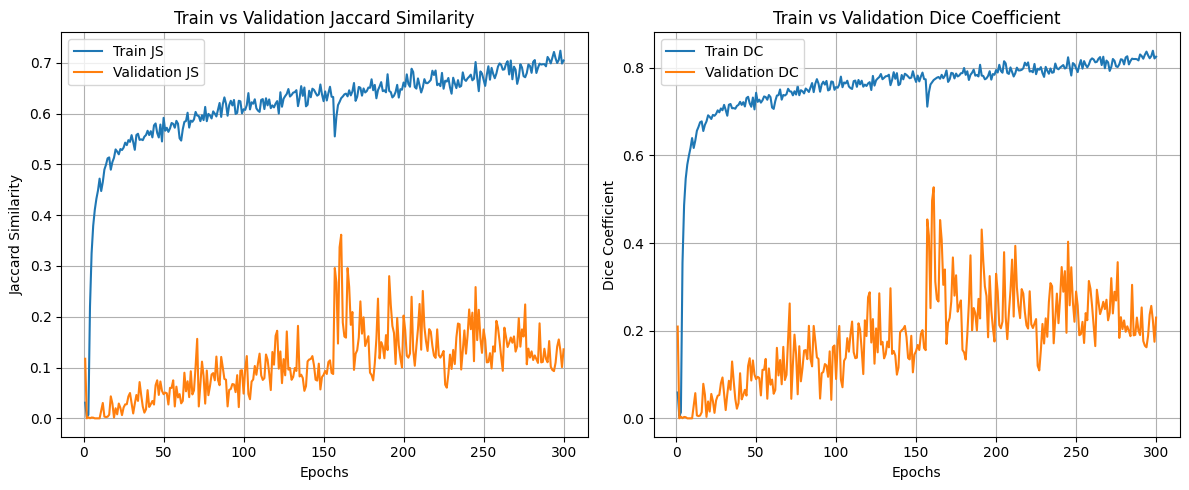

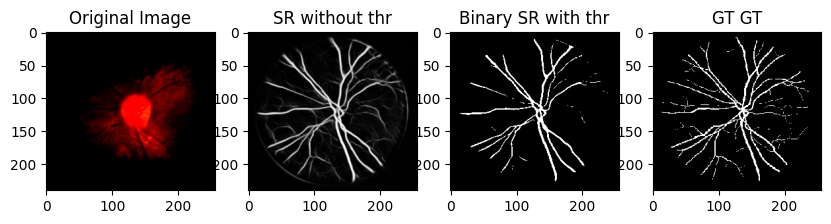

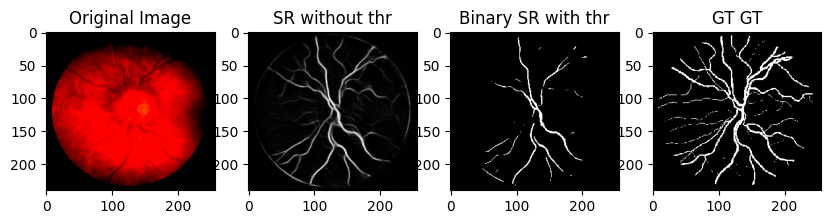

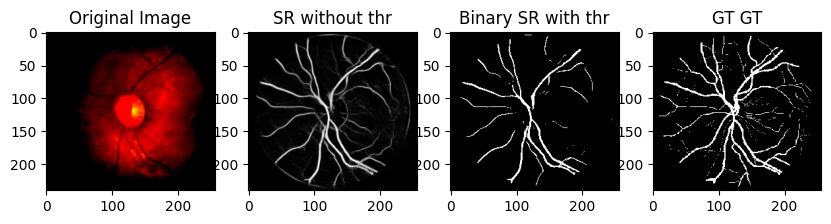

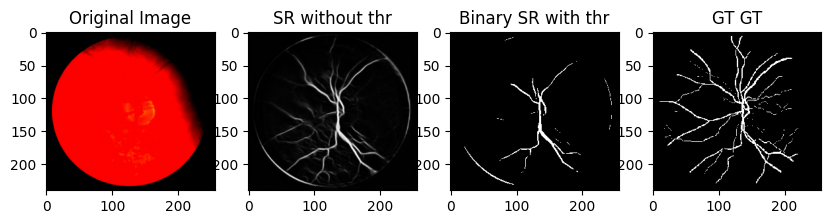

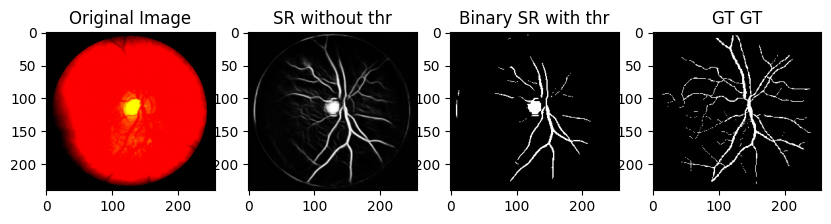

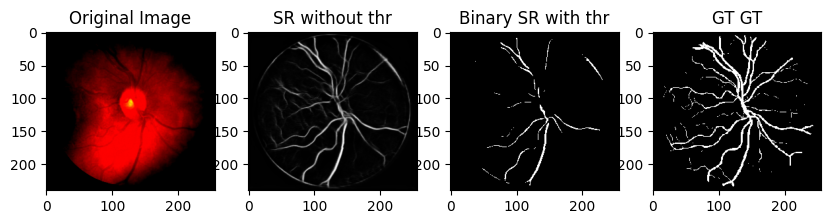

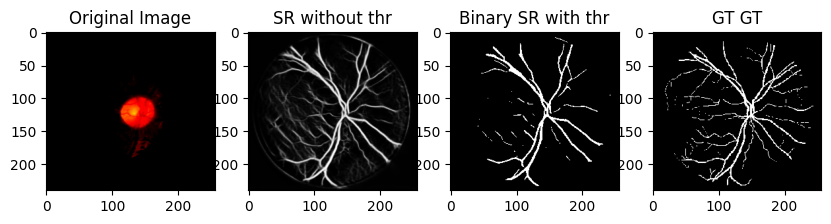

In [41]:
!rm -r CHASEDB1
!rm -r CHASEDB1_GT
!rm -r dataset
!unzip -qq -d CHASEDB1 CHASEDB1.zip
# !rm ./models/*.pkl


def rm_mkdir(dir_path):
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
        print(f'Remove path - {dir_path}')
    os.makedirs(dir_path)
    print(f'Create path - {dir_path}')

def split_data_from_GT(config):
    filenames = os.listdir(config.origin_data_path)
    GT_list = [filename for filename in filenames if filename.endswith('.png')]
    data_list = [filename for filename in filenames if not filename.endswith('.png')]
    for GT in GT_list:
        src = os.path.join(config.origin_data_path, GT)
        dst = os.path.join(config.origin_GT_path, GT)
        copyfile(src, dst)
        os.remove(src)

def prepare_directories(config):
    paths = [
        config.train_path, config.train_GT_path,
        config.valid_path, config.valid_GT_path,
        config.test_path, config.test_GT_path,
        config.origin_GT_path
    ]
    for path in paths:
        rm_mkdir(path)

def split_dataset(config):
    filenames = os.listdir(config.origin_data_path)
    data_list = ['Image_' + filename.split('_')[-1][:-len('.jpg')] + '.jpg' for filename in filenames if filename.endswith('.jpg')]
    GT_list = ['Image_' + filename.split('_')[-1][:-len('.jpg')] + '_1stHO.png' for filename in filenames if filename.endswith('.jpg')]
    num_total = len(data_list)
    num_train = int((config.train_ratio / (config.train_ratio + config.valid_ratio + config.test_ratio)) * num_total)
    num_valid = int((config.valid_ratio / (config.train_ratio + config.valid_ratio + config.test_ratio)) * num_total)
    num_test = num_total - num_train - num_valid
    print(f'\nNum of train set: {num_train}')
    print(f'\nNum of valid set: {num_valid}')
    print(f'\nNum of test set: {num_test}')
    indices = list(range(num_total))
    random.shuffle(indices)
    split_data(indices[:num_train], config.origin_data_path, config.train_path, data_list, GT_list, config.train_GT_path, 'train')
    split_data(indices[num_train:num_train + num_valid], config.origin_data_path, config.valid_path, data_list, GT_list, config.valid_GT_path, 'valid')
    split_data(indices[num_train + num_valid:], config.origin_data_path, config.test_path, data_list, GT_list, config.test_GT_path, 'test')

def split_data(indices, origin_data_path, data_path, data_list, GT_list, GT_path, set_name):
    for i, idx in enumerate(indices):
        src = os.path.join(origin_data_path, data_list[idx])
        dst = os.path.join(data_path, data_list[idx])
        copyfile(src, dst)
        src = os.path.join(config.origin_GT_path, GT_list[idx])
        dst = os.path.join(GT_path, GT_list[idx])
        copyfile(src, dst)
        printProgressBar(i + 1, len(indices), prefix=f'Producing {set_name} set:', suffix='Complete', length=50)

def main(config):
    prepare_directories(config)
    split_data_from_GT(config)
    split_dataset(config)
    if config.mode not in ['train', 'test']:
        print('ERROR!! mode should be selected as train or test')
        return
    if config.mode == 'train' and os.path.exists(config.model_path):
        model_files = os.listdir(config.model_path)
        if len(model_files) != 0:
            os.system(f'rm {os.path.join(config.model_path, model_files[0])}')
    prepare_train_test_environment(config)

def prepare_train_test_environment(config):
    cudnn.benchmark = True
    if config.model_type not in ['U_Net', 'R2U_Net']:
        print(f'ERROR!! model_type should be selected in U_Net/R2U_Net, but your input was {config.model_type}')
        return
    os.makedirs(config.model_path, exist_ok=True)
    config.result_path = os.path.join(config.result_path, config.model_type)
    os.makedirs(config.result_path, exist_ok=True)
    train_loader = get_loader(image_path=config.train_path, image_size=config.image_size, batch_size=config.batch_size, num_workers=config.num_workers, mode='train', augmentation_prob=config.augmentation_prob)
    valid_loader = get_loader(image_path=config.valid_path, image_size=config.image_size, batch_size=config.batch_size, num_workers=config.num_workers, mode='valid', augmentation_prob=0.)
    test_loader = get_loader(image_path=config.test_path, image_size=config.image_size, batch_size=config.batch_size, num_workers=config.num_workers, mode='test', augmentation_prob=0.)
    solver = Solver(config, train_loader, valid_loader, test_loader)
    solver.start()

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--train_ratio', type=float, default=0.6)
    parser.add_argument('--valid_ratio', type=float, default=0.2)
    parser.add_argument('--test_ratio', type=float, default=0.2)
    parser.add_argument('--origin_data_path', type=str, default='./CHASEDB1')
    parser.add_argument('--origin_GT_path', type=str, default='./CHASEDB1_GT')
    parser.add_argument('--train_path', type=str, default='./dataset/train/')
    parser.add_argument('--train_GT_path', type=str, default='./dataset/train_GT/')
    parser.add_argument('--valid_path', type=str, default='./dataset/valid/')
    parser.add_argument('--valid_GT_path', type=str, default='./dataset/valid_GT/')
    parser.add_argument('--test_path', type=str, default='./dataset/test/')
    parser.add_argument('--test_GT_path', type=str, default='./dataset/test_GT/')
    parser.add_argument('--model_type', type=str, default='U_Net', help='U_Net/R2U_Net')
    parser.add_argument('--model_path', type=str, default='./models')
    parser.add_argument('--result_path', type=str, default='./result/')
    parser.add_argument('--image_size', type=int, default=224)
    parser.add_argument('--t', type=int, default=3, help='t for Recurrent step of R2U_Net')
    parser.add_argument('--img_ch', type=int, default=3)
    parser.add_argument('--output_ch', type=int, default=1)
    parser.add_argument('--num_epochs', type=int, default=100)
    parser.add_argument('--num_epochs_decay', type=int, default=70)
    parser.add_argument('--batch_size', type=int, default=1)
    parser.add_argument('--num_workers', type=int, default=8)
    parser.add_argument('--lr', type=float, default=0.0002)
    parser.add_argument('--beta1', type=float, default=0.5)        # momentum1 in Adam
    parser.add_argument('--beta2', type=float, default=0.999)      # momentum2 in Adam
    parser.add_argument('--augmentation_prob', type=float, default=0.4)
    parser.add_argument('--mode', type=str, default='train')
    parser.add_argument('--cuda_idx', type=int, default=1)
    parser.add_argument('--threshold', type=float, default=0.5)
    config = parser.parse_args(args=[
        '--model_type', 'R2U_Net',
        '--num_epochs', '300',
        '--mode', 'train',
        '--augmentation_prob', '0.4',
        '--threshold', '0.5',
    ])
    main(config)

# Main - DRIVE

In [37]:
class DriveDataset(data.Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.transform = transform
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.tif')])
        self.label_paths = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.gif')])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = Image.open(label_path).convert('L')

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        return image, label



def get_drive_dataloaders(image_dir, mask_dir, batch_size, train_ratio=0.6, valid_ratio=0.2, test_ratio=0.2, image_size=224):
    transform = T.Compose([
        T.Resize((image_size, image_size)),
        T.ToTensor()
    ])

    dataset = DriveDataset(image_dir=image_dir, label_dir=mask_dir, transform=transform)
    total_size = len(dataset)
    train_size = int(train_ratio * total_size)
    valid_size = int(valid_ratio * total_size)
    test_size = total_size - train_size - valid_size

    train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader, test_loader

# Usage
image_dir = './DRIVE/training/images'
mask_dir = './DRIVE/training/1st_manual'
batch_size = 1
train_loader, valid_loader, test_loader = get_drive_dataloaders(image_dir, mask_dir, batch_size)


Epoch [1/50], Loss: 7.2726, 
[Training] Acc: 0.9473, SE: 0.0972, SP: 0.9473, PC: 0.0217, F1: 0.0289, JS: 0.0152, DC: 0.0289
Decay learning rate to lr: 0.00019714285714285716.
[Validation] Acc: 0.9890, SE: 0.0000, SP: 0.9890, PC: 0.0000, F1: 0.0000, JS: 0.0000, DC: 0.0000
Epoch [2/50], Loss: 4.2967, 
[Training] Acc: 0.9897, SE: 0.0172, SP: 0.9897, PC: 0.0464, F1: 0.0238, JS: 0.0124, DC: 0.0238
Decay learning rate to lr: 0.0001942857142857143.
[Validation] Acc: 0.9935, SE: 0.0000, SP: 0.9935, PC: 0.0000, F1: 0.0000, JS: 0.0000, DC: 0.0000
Epoch [3/50], Loss: 3.3996, 
[Training] Acc: 0.9912, SE: 0.0040, SP: 0.9912, PC: 0.0152, F1: 0.0061, JS: 0.0031, DC: 0.0061
Decay learning rate to lr: 0.00019142857142857145.
[Validation] Acc: 0.9935, SE: 0.0000, SP: 0.9935, PC: 0.0000, F1: 0.0000, JS: 0.0000, DC: 0.0000
Epoch [4/50], Loss: 2.8947, 
[Training] Acc: 0.9915, SE: 0.0665, SP: 0.9915, PC: 0.3137, F1: 0.0953, JS: 0.0532, DC: 0.0953
Decay learning rate to lr: 0.0001885714285714286.
[Validation

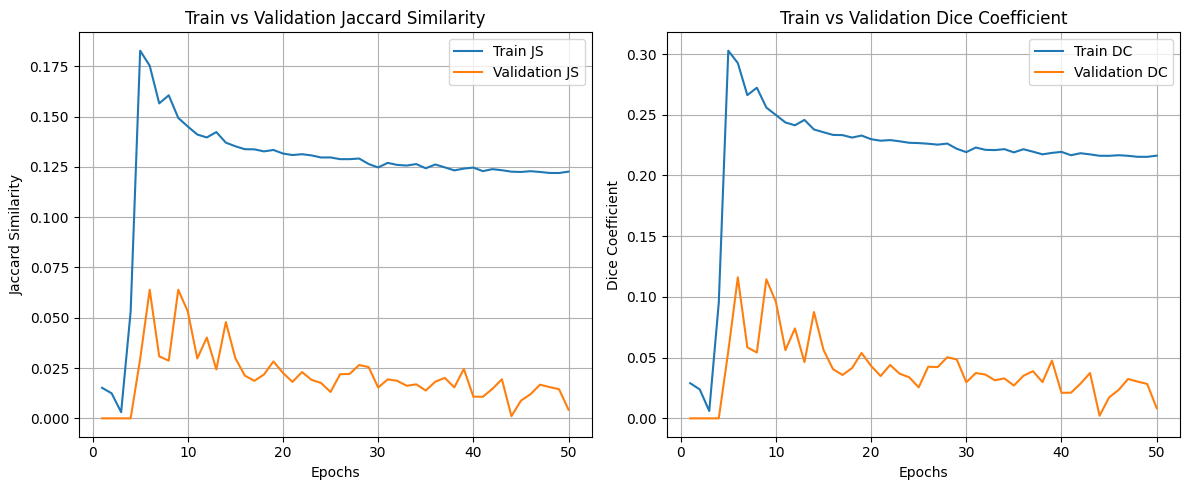

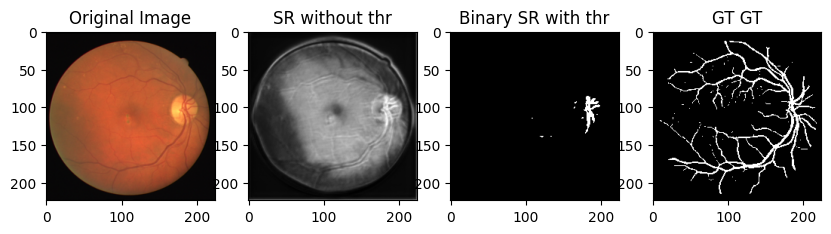

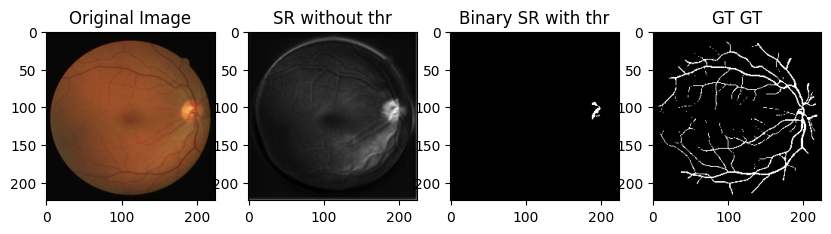

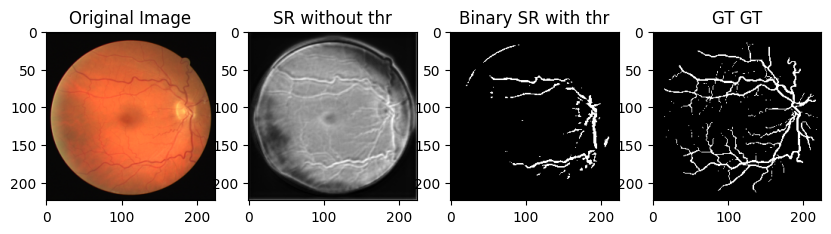

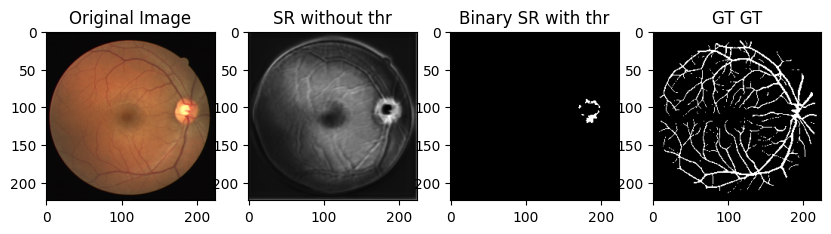

In [42]:

def main(config):
    if config.mode not in ['train', 'test']:
        print('ERROR!! mode should be selected as train or test')
        return
    if config.mode == 'train' and os.path.exists(config.model_path):
        model_files = os.listdir(config.model_path)
        if len(model_files) != 0:
            os.system(f'rm {os.path.join(config.model_path, model_files[0])}')
    prepare_train_test_environment(config)

def prepare_train_test_environment(config):
    cudnn.benchmark = True
    if config.model_type not in ['U_Net', 'R2U_Net']:
        print(f'ERROR!! model_type should be selected in U_Net/R2U_Net, but your input was {config.model_type}')
        return
    train_loader, valid_loader, test_loader = get_drive_dataloaders(config.origin_data_path, config.origin_GT_path, config.batch_size)
    solver = Solver(config, train_loader, valid_loader, test_loader)
    solver.start()

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--train_ratio', type=float, default=0.6)
    parser.add_argument('--valid_ratio', type=float, default=0.2)
    parser.add_argument('--test_ratio', type=float, default=0.2)
    parser.add_argument('--origin_data_path', type=str, default='./DRIVE/training/images')
    parser.add_argument('--origin_GT_path', type=str, default='./DRIVE/training/1st_manual')
    parser.add_argument('--train_path', type=str, default='./dataset/train/')
    parser.add_argument('--train_GT_path', type=str, default='./dataset/train_GT/')
    parser.add_argument('--valid_path', type=str, default='./dataset/valid/')
    parser.add_argument('--valid_GT_path', type=str, default='./dataset/valid_GT/')
    parser.add_argument('--test_path', type=str, default='./dataset/test/')
    parser.add_argument('--test_GT_path', type=str, default='./dataset/test_GT/')
    parser.add_argument('--model_type', type=str, default='U_Net', help='U_Net/R2U_Net')
    parser.add_argument('--model_path', type=str, default='./models')
    parser.add_argument('--result_path', type=str, default='./result/')
    parser.add_argument('--image_size', type=int, default=224)
    parser.add_argument('--t', type=int, default=3, help='t for Recurrent step of R2U_Net or R2AttU_Net')
    parser.add_argument('--img_ch', type=int, default=3)
    parser.add_argument('--output_ch', type=int, default=1)
    parser.add_argument('--num_epochs', type=int, default=100)
    parser.add_argument('--num_epochs_decay', type=int, default=70)
    parser.add_argument('--batch_size', type=int, default=1)
    parser.add_argument('--num_workers', type=int, default=8)
    parser.add_argument('--lr', type=float, default=0.0002)
    parser.add_argument('--beta1', type=float, default=0.5)        # momentum1 in Adam
    parser.add_argument('--beta2', type=float, default=0.999)      # momentum2 in Adam
    parser.add_argument('--augmentation_prob', type=float, default=0.4)
    parser.add_argument('--mode', type=str, default='train')
    parser.add_argument('--cuda_idx', type=int, default=1)
    parser.add_argument('--threshold', type=float, default=0.5)
    config = parser.parse_args(args=[
        '--model_type', 'R2U_Net',
        '--num_epochs', '50',
        '--mode', 'train',
        '--augmentation_prob', '0.4',
        '--threshold', '0.5',
    ])
    main(config)